# Visualizing Datasets with Howso Engine and UMAP

## Overview

This notebook will demonstrate Howso Engine's ability to calculate pairwise distances for training cases
and feed them into [UMAP](https://github.com/lmcinnes/umap) to visualize high-dimensionality datasets.

In [1]:
import os
import warnings

import plotly.express as px
import plotly.io as pio
import pmlb

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import umap
    import umap.plot

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

## Step 1: Load a Dataset

We use the Iris dataset.

In [2]:
df = pmlb.fetch_data("iris", local_cache_dir="../data")

df

,sepal-length,sepal-width,petal-length,petal-width,target
0,6.7,3.0,5.2,2.3,2
1,6.0,2.2,5.0,1.5,2
2,6.2,2.8,4.8,1.8,2
3,7.7,3.8,6.7,2.2,2
4,7.2,3.0,5.8,1.6,2
...,...,...,...,...,...
145,5.0,3.5,1.6,0.6,0
146,5.4,3.9,1.7,0.4,0
147,5.1,3.4,1.5,0.2,0
148,5.0,3.6,1.4,0.2,0


## Step 2: Create the Trainee, Train, and Analyze

For questions about the specific steps of this section, please see the [basic workflow guide](https://docs.howso.com/user_guide/basics/basic_workflow.html).

In [3]:
features = infer_feature_attributes(df)
action_feature = "target"
context_features = features.get_names(without=[action_feature])

t = Trainee(features=features)
t.train(df, skip_auto_analyze=True)
t.analyze(context_features=context_features, action_features=[action_feature])

## Step 3: Get UMAP Parameters from the Trainee

The parameters needed for UMAP are the distances, the number of neighbors, the minimum distance. We use the
`get_distances` call to get the distances. For the remainder, we use `k` from the hyperparameter map for the
former and half of the minimum observed distance for the latter.

In [4]:
# The action feature is used to determine which hyperparameters to use when computing distances.
distances = t.get_distances(
    features=context_features,
    action_feature=action_feature
)["distances"]

hyperparameter_map = t.get_params(
    context_features=context_features,
    action_feature=action_feature,
)["hyperparameter_map"]

k = hyperparameter_map["k"]
p = hyperparameter_map["p"]

residuals = t.react_aggregate(
    context_features=context_features,
    action_feature=action_feature,
    details={"feature_residuals_full": True}
)
# Take the p-norm of the residuals to use as the min_dist
min_dist = float((residuals.values ** p).sum() ** (1 / p))
min_dist = min(round(min_dist, 3), 1)

print(f"{k=}, {min_dist=}")
distances

k=21, min_dist=0.447


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.794773,1.483106,1.094206,2.033576,1.251097,2.320161,1.244279,2.083301,2.243558,1.820783,...,2.432872,1.767133,1.246897,1.372492,0.990822,4.372369,4.298295,4.579264,4.713071,4.445467
1,1.483106,0.794773,1.029974,2.981363,1.728668,1.514714,0.920779,1.344431,1.735424,1.299293,...,1.618823,1.291031,1.220676,1.062420,1.268017,3.898471,3.943939,4.043266,4.212060,3.917971
2,1.094206,1.029974,0.794773,2.671229,1.555605,1.574225,0.877047,1.362077,1.563377,1.158913,...,1.681087,1.152006,1.024642,0.887458,0.945731,3.709753,3.688262,3.898757,4.042202,3.763683
3,2.033576,2.981363,2.671229,0.794773,1.548811,4.055335,2.665367,3.829059,3.962419,3.454722,...,4.155136,3.366387,2.498108,2.846636,2.231168,6.006193,5.804195,6.170237,6.289301,6.067187
4,1.251097,1.728668,1.555605,1.548811,0.794773,2.763211,1.537237,2.576594,2.778246,2.268451,...,2.854562,2.276643,1.302578,1.670677,1.173912,4.882308,4.729837,5.014247,5.158539,4.919366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,4.372369,3.898471,3.709753,6.006193,4.882308,2.610431,3.881177,2.785743,2.344743,2.892142,...,2.510500,3.156271,3.835199,3.464939,4.004861,0.794773,0.958462,0.887458,0.895999,0.818601
146,4.298295,3.943939,3.688262,5.804195,4.729837,2.729615,3.875408,2.890911,2.400885,2.904940,...,2.629831,3.190063,3.724216,3.420931,3.898184,0.958462,0.794773,0.980952,0.961065,0.981381
147,4.579264,4.043266,3.898757,6.170237,5.014247,2.744783,4.052422,2.951236,2.536542,3.066284,...,2.629896,3.361408,3.961552,3.625246,4.167713,0.887458,0.980952,0.794773,0.822787,0.823171
148,4.713071,4.212060,4.042202,6.289301,5.158539,2.915873,4.197758,3.110539,2.676849,3.205218,...,2.804410,3.483449,4.118478,3.767951,4.309665,0.895999,0.961065,0.822787,0.794773,0.850379


## Step 4: Plot the Dataset using UMAP

Finally, we use the parameters and distance from the Trainee

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    points = umap.UMAP(metric="precomputed", n_neighbors=k, min_dist=min_dist).fit_transform(distances)

In [6]:
points.shape

(150, 2)

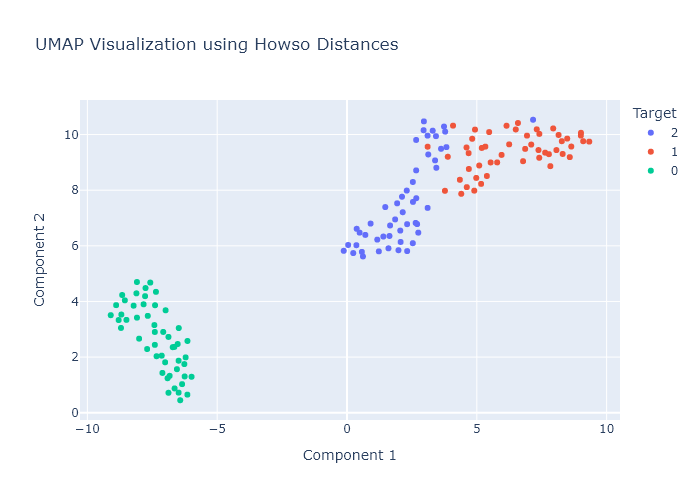

In [7]:
fig = px.scatter(
    x=points[:, 0],
    y=points[:, 1],
    color=df[action_feature].astype(object),
    title="UMAP Visualization using Howso Distances",
    labels={
        "x": "Component 1",
        "y": "Component 2",
        "color": "Target"
    },
)
fig.show()